In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.ml.recommendation import ALS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
movie_data = pd.read_csv('data/movies.dat',
                                   sep="\t|::",
                                   names=['movie_id','title','genres'], 
                                   header=None, 
                                   engine="python")

In [3]:
def load_data_to_spark():
    df = pd.read_csv('data/training.csv')
    df = df.drop(columns='timestamp')
    spark = SparkSession.builder.getOrCreate()
    s_df = spark.createDataFrame(df)
    return s_df, df
s_df, p_df = load_data_to_spark()

In [4]:
s_df.show()

+----+-----+------+
|user|movie|rating|
+----+-----+------+
|6040|  858|     4|
|6040|  593|     5|
|6040| 2384|     4|
|6040| 1961|     4|
|6040| 2019|     5|
|6040| 1419|     3|
|6040|  573|     4|
|6040| 3111|     5|
|6040|  213|     5|
|6040| 3505|     4|
|6040| 1734|     2|
|6040|  912|     5|
|6040|  919|     5|
|6040| 2503|     5|
|6040|  527|     5|
|6040|  318|     4|
|6040| 1252|     5|
|6040|  649|     5|
|6040| 3289|     5|
|6040|  759|     5|
+----+-----+------+
only showing top 20 rows



In [5]:
p_df

,user,movie,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5
...,...,...,...
799995,1875,2940,5
799996,1875,589,4
799997,1875,110,4
799998,1875,2791,3


In [6]:
def get_density():
    # get density from original data
    p_df, _ = load_data_to_spark()
    n_ratings = s_df.count()
    n_users = s_df.select('user').distinct().count()
    n_movies = s_df.select('movie').distinct().count()
    density = n_ratings / (n_users * n_movies)
    print('The original density is: {} '.format(density))
    return density

In [ ]:
get_density()
get_density()

In [8]:


print('Number of unique users: {}'.format(s_df.select('user').distinct().count()))
print('Number of unique movies: {}'.format(s_df.select('movie').distinct().count()))
print('Number of rating: {}'.format(s_df.count()))



Number of unique users: 5399
Number of unique movies: 3662
Number of rating: 800000


In [9]:
def traintestsplit():
    ratings_df, _ = load_data_to_spark()
    train, test = ratings_df.randomSplit([0.8, 0.2], seed=427471138)
    return train, test

In [10]:
train, test = traintestsplit()

In [11]:
def get_train_density():
    # get density from original data
    train, _ = traintestsplit()
    n_ratings = train.count()
    n_users = train.select('user').distinct().count()
    n_movies = train.select('movie').distinct().count()
    density = n_ratings / (n_users * n_movies)
    print('The train desnsity is: {} '.format(density))
    return density

In [13]:
def get_test_density():
    # get density from original data
    _, test = traintestsplit()
    n_ratings = test.count()
    n_users = test.select('user').distinct().count()
    n_movies = test.select('movie').distinct().count()
    density = n_ratings / (n_users * n_movies)
    print('The test desnsity is: {} '.format(density))
    return density

In [14]:
get_density()

The original density is: 0.04046302241176001 


0.04046302241176001

In [15]:
get_train_density()

The train desnsity is: 0.03271967148547561 


0.03271967148547561

In [16]:
get_test_density()

The test desnsity is: 0.008720338117892072 


0.008720338117892072

Max Ratings: 1509
Min Ratings: 1


<AxesSubplot:>

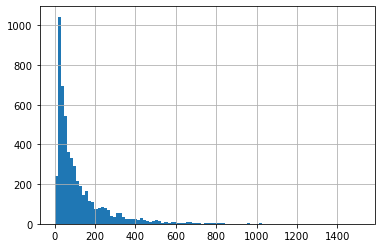

In [17]:
# train user
user_count = train.groupBy('user').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 2317
Min Ratings: 1


<AxesSubplot:>

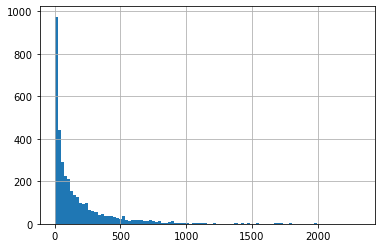

In [21]:
# train movie
movie_count = train.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

Max Ratings: 340
Min Ratings: 1


<AxesSubplot:>

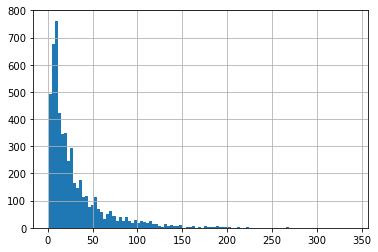

In [22]:
# test user
user_count = test.groupBy('user').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 584
Min Ratings: 1


<AxesSubplot:>

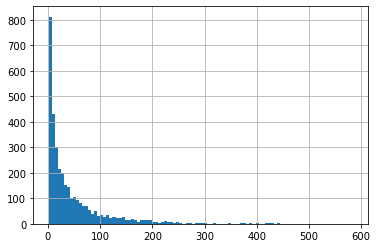

In [24]:
# test movie
movie_count = test.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

# The Model

In [34]:
# instantiate the model and set its parameters
als_model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10) 

In [35]:
# fitting
recommender = als_model.fit(train)

In [45]:
user_factor_df = recommender.userFactors.filter('id = 1')
item_factor_df = recommender.itemFactors.filter('id = 100')

In [46]:
item_factor_df.show()

+---+--------------------+
| id|            features|
+---+--------------------+
|100|[0.7274901, 0.467...|
+---+--------------------+



In [47]:
user_factor_df.show()

+---+--------+
| id|features|
+---+--------+
+---+--------+

